In [1]:
from tqdm import TqdmWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmWarning)
from tqdm.auto import tqdm  # will not emit the IProgress warning now

In [2]:
from utils import base_configs, deps, tr_va_te_split #, models_def, shap_explain
from utils.helpers import rw_csv_helpers, feature_distr_helpers, logging_helpers, tr_va_te_eval_helpers, tr_va_te_result_plot

In [3]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
# import utils._1_3_train_valid_test_split as _1_3_tvts
# import utils._2_ml_rf as _2_ml_rf

### 0 Data load

In [4]:
CONFIGS = base_configs.get_base_configs()

df_hints6 = "ip/3_cleanedEncoded/hints6_public_filtered_v1_cleaned_encoded.csv"
df_hints7 = "ip/3_cleanedEncoded/....csv"
df_hints6_7 = "ip/3_cleanedEncoded/hints6_7_cleaned_encoded.csv"
df_orig = rw_csv_helpers.read_csv_file(df_hints6, verbose = 1)
# Alternatively,
# df_orig = rw_csv_helpers.read_csv_file(CONFIGS['IP_CSV_HINTS6_CLEANED_ENCODED'], verbose = 1)


Loaded: /home/ppanta/puru_proj/proj_v0/hints6_v0/ip/3_cleanedEncoded/hints6_public_filtered_v1_cleaned_encoded.csv
────────────────────────────────────────────────────────────────────────────────
Shape: (4865, 27)
────────────────────────────────────────────────────────────────────────────────
All columns: ['FreqGoProvider', 'Deaf', 'MedConditions_Diabetes', 'MedConditions_HighBP', 'MedConditions_HeartCondition', 'MedConditions_LungDisease', 'MedConditions_Depression', 'AverageSleepNight', 'AverageTimeSitting', 'EverHadCancer', 'Age', 'BirthGender', 'BMI', 'PHQ4', 'WeeklyMinutesModerateExercise', 'AvgDrinksPerWeek', 'GeneralHealth_Excellent', 'GeneralHealth_VeryGood', 'GeneralHealth_Good', 'GeneralHealth_Fair', 'GeneralHealth_Poor', 'smokeStat_Current', 'smokeStat_Former', 'smokeStat_Never', 'eCigUse_Current', 'eCigUse_Former', 'eCigUse_Never']


In [5]:
df = df_orig.copy()
target_col_name = CONFIGS['TARGET_COL_NAME'] # "MedConditions_HeartCondition"
counts = feature_distr_helpers.count01(df.copy(), target_col_name, verbose=1)

Counts for column 'MedConditions_HeartCondition' (only 0 and 1):
MedConditions_HeartCondition
0    4412
1     453
Name: count, dtype: int64
Total (0/1 only): 4865


### 1 Train - Validation - Test split

In [6]:
def TrainValidTestSplit(CONFIGS, df, target_col_name):
    
    df = df.copy()
    # target_col_name = CONFIGS['TARGET_COL_NAME'] # "MedConditions_HeartCondition"
    X = df.drop(columns=[target_col_name])
    y = df[target_col_name]
    
    # 5) run the pipeline
    result = tr_va_te_split.data_preprocessing(
        CONFIGS=CONFIGS,
        verbose=3,                         # 0 mute; 1 basic; 2 detailed; 3 full
        X=X, y=y,
        balance_method="adasyn",           # 'adasyn' | 'smote' | 'smoteenn' | 'none'
        balance_kwargs={"n_neighbors": 5}, # optional
        balance_val_for_diagnostics=True,  # get X_val_bal / y_val_bal for inspection
    )

    return result

result = TrainValidTestSplit(CONFIGS=CONFIGS, df=df.copy(), target_col_name=target_col_name)

▸ Split 60/20/20 complete.
  - X shape: (4865, 26) | features: 26
  - y name: 'MedConditions_HeartCondition' | classes: {0: 4412, 1: 453}
  - Train: 2919 | Val: 973 | Test: 973
  - y distribution by split → train={0: 2647, 1: 272}, val={0: 882, 1: 91}, test={0: 883, 1: 90}
▸ Balancing (train) with 'adasyn'
    class 0: 2647 (90.7%) → 2647 (50.2%)
    class 1: 272 (9.3%) → 2624 (49.8%)
▸ Validation (diagnostic) balanced (not used for selection).
▸ Scaling with StandardScaler (fit on balanced train).
────────────────────────────────────────────────────────
Preprocessing report (basic)
• Features: 26 | Target: 'MedConditions_HeartCondition'
• Total rows: 4,865
• Split sizes 60/20/20 → Train: 2,919 | Val: 973 | Test: 973
• y distribution (orig): {0: 4412, 1: 453}

Balancing (train only)
• Method: adasyn
  - class 0: 2647 (90.7%) → 2647 (50.2%)
  - class 1: 272 (9.3%) → 2624 (49.8%)

Scaling (fit on balanced train)
• X_train_res_scaled shape: (5271, 26)
• X_val_scaled shape:       (973, 26)

### 2 Train - Validation - Test value assignments

In [7]:
print_result = feature_distr_helpers.print_shapes_and_features(result = result, verbose = 1)

# Value assignments for further calculations
X_train_res_scaled = result['X_train_res_scaled']
X_val_scaled       = result['X_val_scaled']
X_test_scaled      = result['X_test_scaled']

X_train     = result['X_train']
X_train_res = result['X_train_res']
X_val       = result['X_val']
X_test      = result['X_test']

y_train     = result['y_train']
y_train_res = result['y_train_res']
y_val       = result['y_val']
y_test      = result['y_test']

features    = result['features']


X_train shape:            X = (2919, 26),      y = (2919,)
X_train_res shape:        X = (5271, 26),  y = (5271,)
X_val shape:              X = (973, 26),        y = (973,)
X_test shape:             X = (973, 26),       y = (973,)
X_train_res_scaled shape: X = (5271, 26)
X_val_scaled shape:       X = (973, 26)
X_test_scaled shape:      X = (973, 26)
features length:          n = 26


In [8]:
distr_df = feature_distr_helpers.summarize_y_distributions(result)
print(distr_df)

                n  0_count  0_pct  1_count  1_pct
y_test        973      883  90.75       90   9.25
y_train      2919     2647  90.68      272   9.32
y_train_res  5271     2647  50.22     2624  49.78
y_val         973      882  90.65       91   9.35
y_val_bal    1743      882  50.60      861  49.40


In [9]:
# ============================================================
# Load & wrap your already-prepared splits (from result[...])
# ============================================================
with logging_helpers.Timer("Load & wrap data"):
    logging_helpers.stamp(f"CUDA available: {CONFIGS['USE_GPU']} (device={CONFIGS['DEVICE']})")
    X_train_res_scaled = logging_helpers.to_df(X_train_res_scaled, features)
    X_val_scaled       = logging_helpers.to_df(X_val_scaled,       features)
    X_test_scaled      = logging_helpers.to_df(X_test_scaled,      features)
    X_train     = logging_helpers.to_df(X_train,     features)
    X_train_res = logging_helpers.to_df(X_train_res, features)
    X_val       = logging_helpers.to_df(X_val,       features)
    X_test      = logging_helpers.to_df(X_test,      features)
    y_train     = logging_helpers.to_series(y_train)
    y_train_res = logging_helpers.to_series(y_train_res)
    y_val       = logging_helpers.to_series(y_val)
    y_test      = logging_helpers.to_series(y_test)
    feat_names  = list(X_train.columns)
    logging_helpers.stamp(f"Train_res shape (unscaled): {X_train_res.shape}")
    logging_helpers.stamp(f"Val shape (unscaled):       {X_val.shape}")


[20:07:45] START: Load & wrap data
[20:07:45] CUDA available: True (device=cuda)
[20:07:45] Train_res shape (unscaled): (5271, 26)
[20:07:45] Val shape (unscaled):       (973, 26)
[20:07:45] END:   Load & wrap data  (took 0.02s)



In [10]:
###########################################
########## RELOADING THE MODULE: ##########
###########################################
import importlib
import utils.models_def as models_def 
import utils.base_configs as base_configs 
importlib.reload(base_configs)
importlib.reload(models_def)
# CONFIGS = base_configs.get_base_configs()

<module 'utils.models_def' from '/home/ppanta/puru_proj/proj_v0/hints6_v0/utils/models_def.py'>

### 3 Train - Validation - Test the models

In [11]:
from utils import pipeline_lr as pipeline_lr
import importlib
importlib.reload(pipeline_lr)

<module 'utils.pipeline_lr' from '/home/ppanta/puru_proj/proj_v0/hints6_v0/utils/pipeline_lr.py'>

In [12]:
results = {}

[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/lr
[LR] Hyperparam scan (C):
  C=0.01    val_logloss=0.4205  val_auc_roc=0.7138
  C=0.03    val_logloss=0.3711  val_auc_roc=0.7170
  C=0.1     val_logloss=0.3329  val_auc_roc=0.7317
  C=0.3     val_logloss=0.3101  val_auc_roc=0.7476
  C=1.0     val_logloss=0.2960  val_auc_roc=0.7606
  C=3.0     val_logloss=0.2905  val_auc_roc=0.7670
  C=10.0    val_logloss=0.2887  val_auc_roc=0.7691
[LR] Best C=10.0 selected by val_logloss (tie-break AUC-ROC).
[LR] Isotonic calibration done via manual isotonic regression on validation.
[LR][THRESH] best_t=0.150 (f1=0.3547)

Best threshold (optimized on F1 using positive-class F1): 0.15

Validation metrics (calibrated, threshold = 0.15):
  Accuracy       : 0.783
  AUC-ROC        : 0.787
  AUC-PR         : 0.265
  Brier          : 0.0748
  MCC            : 0.296
  F1 (macro_avg) : 0.612

Classification Report (Validation):
              precision    

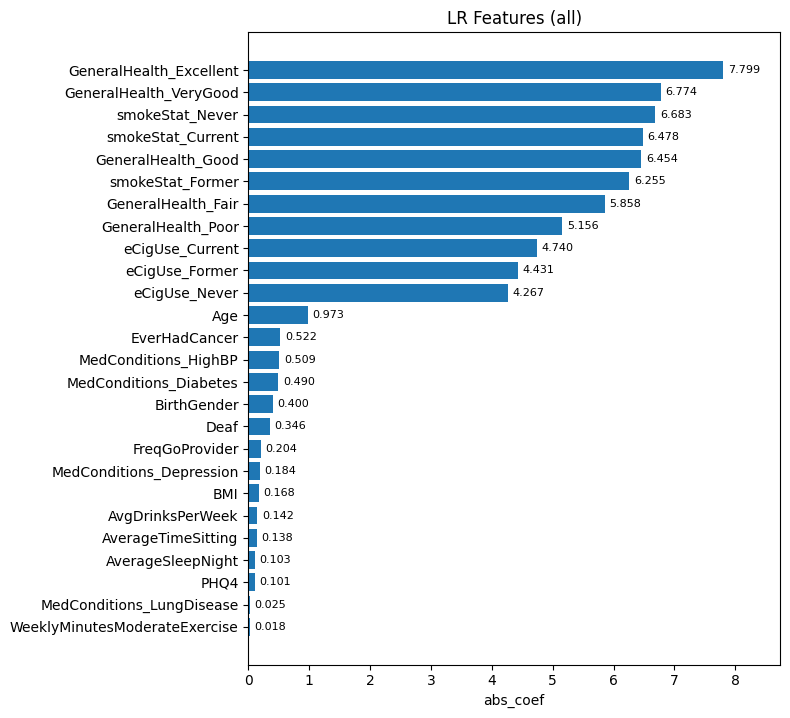

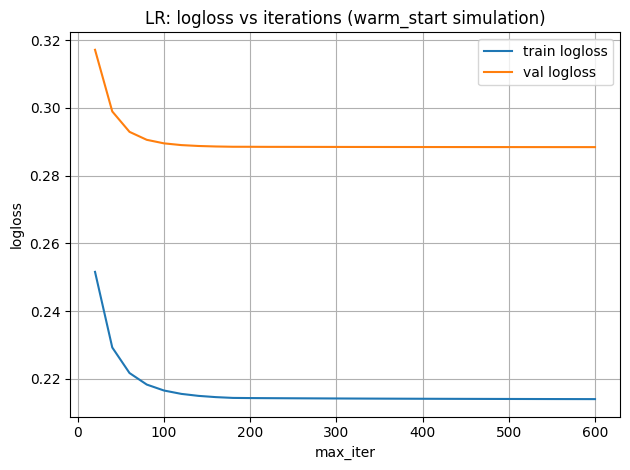

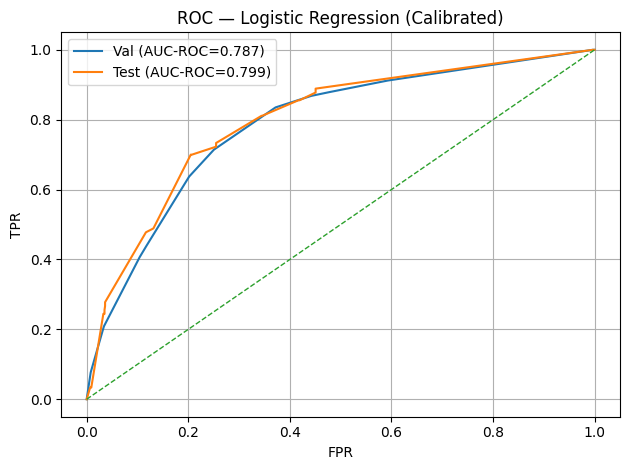

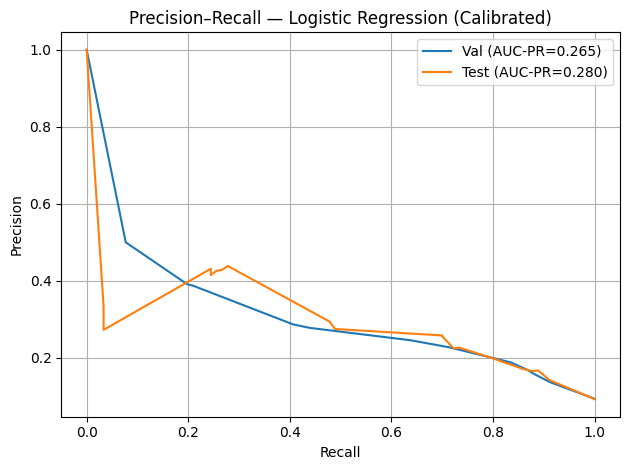

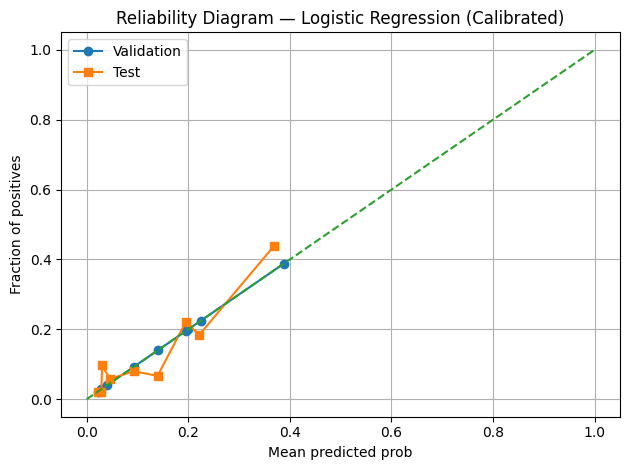

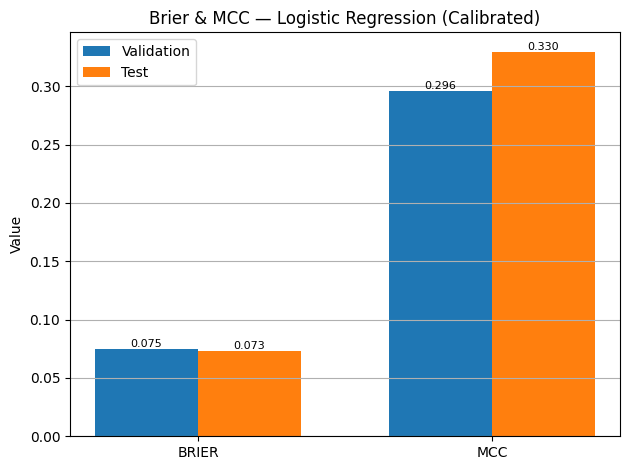

In [13]:
# Control how many features to export/plot:
# - set explicitly via topn_features (e.g., 30)
# - or set CONFIGS['LR_TOPN_FEATURES'] (overrides the arg if present)
topn = CONFIGS.get('LR_TOPN_FEATURES', 30)   # use None or 0 for ALL features

results["lr"] = pipeline_lr.train_validate_test_lr(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    C_grid=[0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0],
    penalty="l2",
    prefer_saga=True,
    max_iter=600,
    threshold_metric="f1",           # or "youden"
    topn_features=topn,              # <— controls feature export; 0/None = ALL
    CONFIGS=CONFIGS,
    save_outputs=True
)


[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/rf
[RF] Hyperparam scan (n_estimators, max_depth, min_samples_leaf):
  n=300  depth=None  leaf=1   val_logloss=0.3429  val_auc_roc=0.7177
  n=300  depth=None  leaf=2   val_logloss=0.3136  val_auc_roc=0.7167
  n=300  depth=None  leaf=4   val_logloss=0.3245  val_auc_roc=0.7124
  n=300  depth=12    leaf=1   val_logloss=0.3199  val_auc_roc=0.7178
  n=300  depth=12    leaf=2   val_logloss=0.3244  val_auc_roc=0.7133
  n=300  depth=12    leaf=4   val_logloss=0.3294  val_auc_roc=0.7158
  n=300  depth=20    leaf=1   val_logloss=0.3145  val_auc_roc=0.7089
  n=300  depth=20    leaf=2   val_logloss=0.3145  val_auc_roc=0.7139
  n=300  depth=20    leaf=4   val_logloss=0.3246  val_auc_roc=0.7117
  n=600  depth=None  leaf=1   val_logloss=0.3098  val_auc_roc=0.7178
  n=600  depth=None  leaf=2   val_logloss=0.3153  val_auc_roc=0.7124
  n=600  depth=None  leaf=4   val_logloss=0.3242  val_auc_roc=0.71

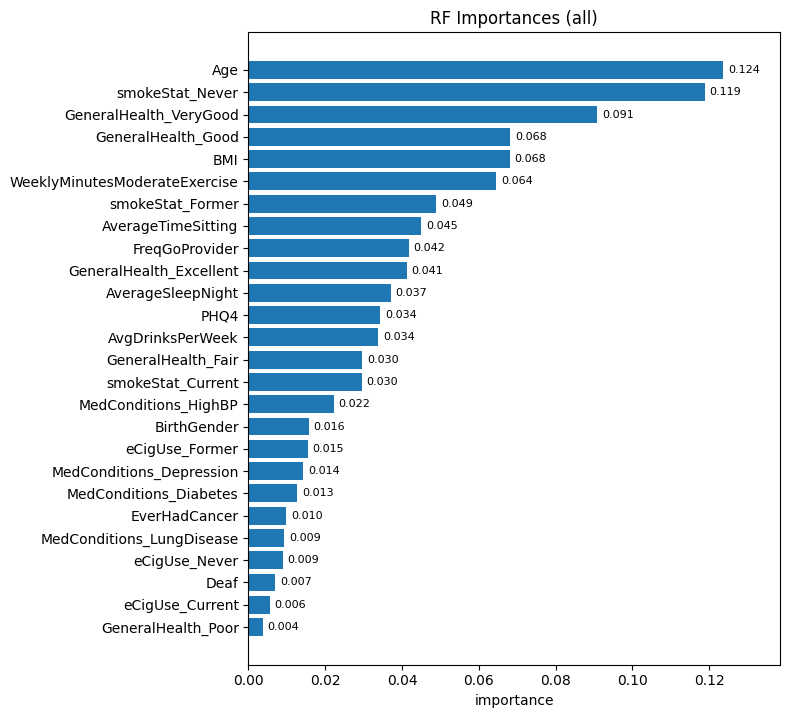

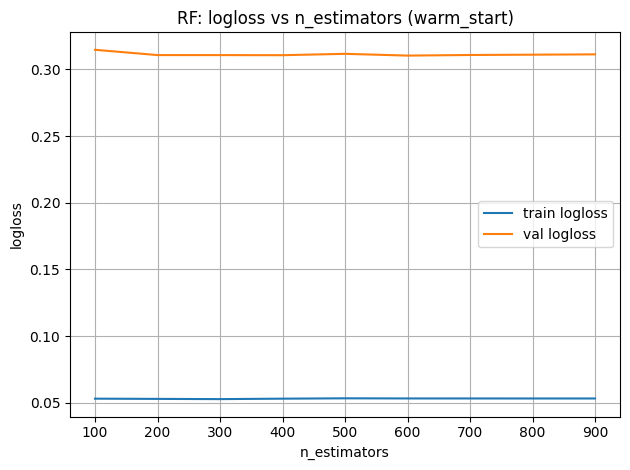

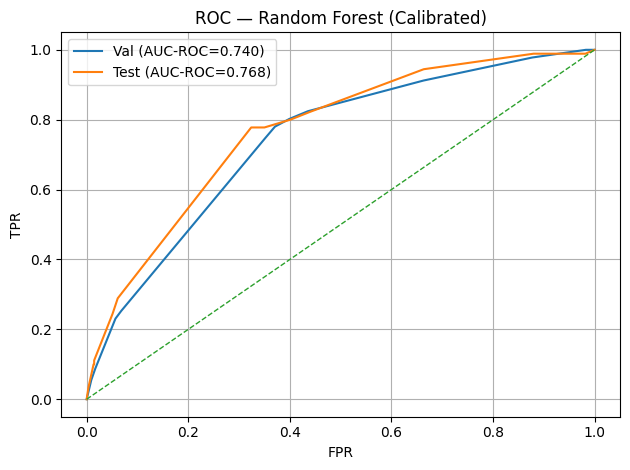

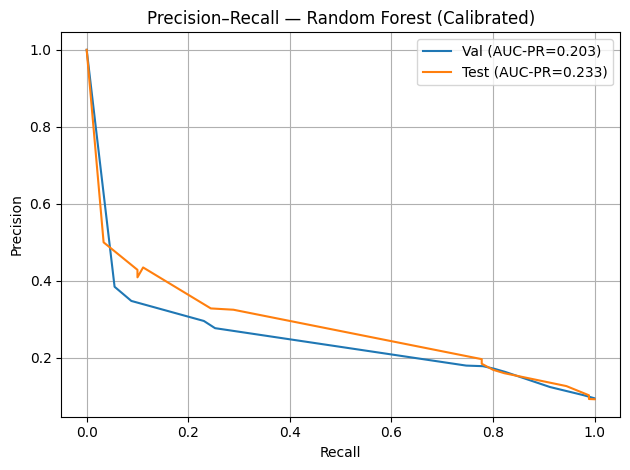

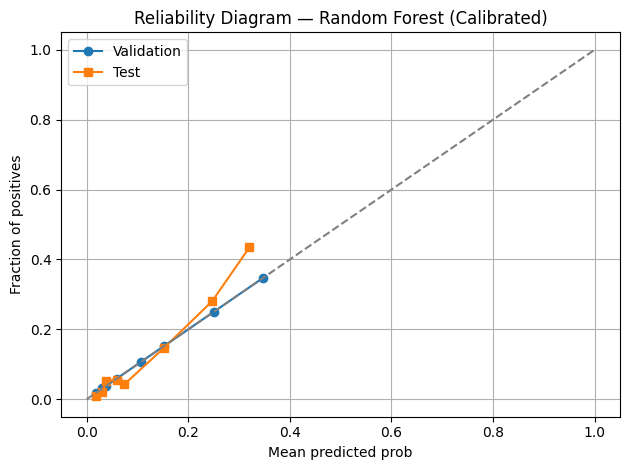

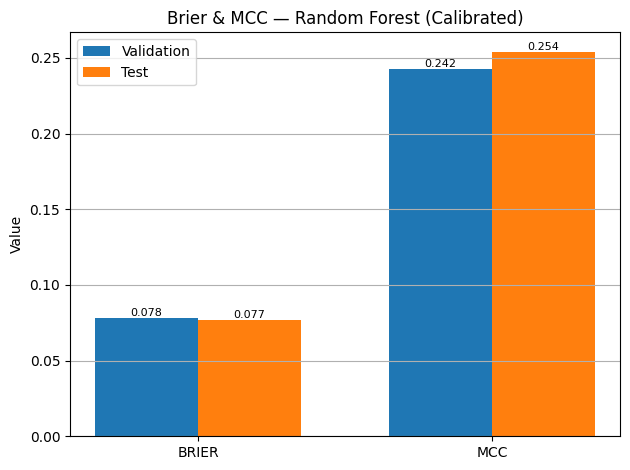

In [14]:
from utils import pipeline_rf as pipeline_rf
import importlib
importlib.reload(pipeline_rf)

results["rf"] = pipeline_rf.train_validate_test_rf(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    n_estimators_grid=[300, 600, 900],
    max_depth_grid=[None, 12, 20],
    min_samples_leaf_grid=[1, 2, 4],
    max_features="sqrt",
    class_weight="balanced_subsample",
    warm_curve_step=100,
    max_estimators_curve=900,
    random_state=CONFIGS.get('RANDOM_STATE', 42),
    threshold_metric="f1",             # or "youden"
    topn_features=CONFIGS.get('RF_TOPN_FEATURES', 30),   # 0/None => ALL
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved RF outputs dir:", results["rf"]["outdir"])
print("RF used top-n:", results["rf"]["used_topn_features"])
print(results["rf"]["features"].head(10).to_string(index=False))


[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/xgb
[XGB] Hyperparam scan:
  n=600  lr=0.03 depth=4  mcw=1.0 sub=0.8 col=0.7  val_logloss=0.3060  val_auc_roc=0.7242  (best_it=372)
  n=600  lr=0.03 depth=4  mcw=1.0 sub=0.8 col=0.9  val_logloss=0.3071  val_auc_roc=0.7240  (best_it=355)
  n=600  lr=0.03 depth=4  mcw=3.0 sub=0.8 col=0.7  val_logloss=0.3050  val_auc_roc=0.7190  (best_it=483)
  n=600  lr=0.03 depth=4  mcw=3.0 sub=0.8 col=0.9  val_logloss=0.3050  val_auc_roc=0.7224  (best_it=441)
  n=600  lr=0.03 depth=6  mcw=1.0 sub=0.8 col=0.7  val_logloss=0.3017  val_auc_roc=0.7269  (best_it=274)
  n=600  lr=0.03 depth=6  mcw=1.0 sub=0.8 col=0.9  val_logloss=0.3014  val_auc_roc=0.7327  (best_it=158)
  n=600  lr=0.03 depth=6  mcw=3.0 sub=0.8 col=0.7  val_logloss=0.3025  val_auc_roc=0.7226  (best_it=290)
  n=600  lr=0.03 depth=6  mcw=3.0 sub=0.8 col=0.9  val_logloss=0.2989  val_auc_roc=0.7349  (best_it=177)
  n=600  lr=0.03 depth=8  m

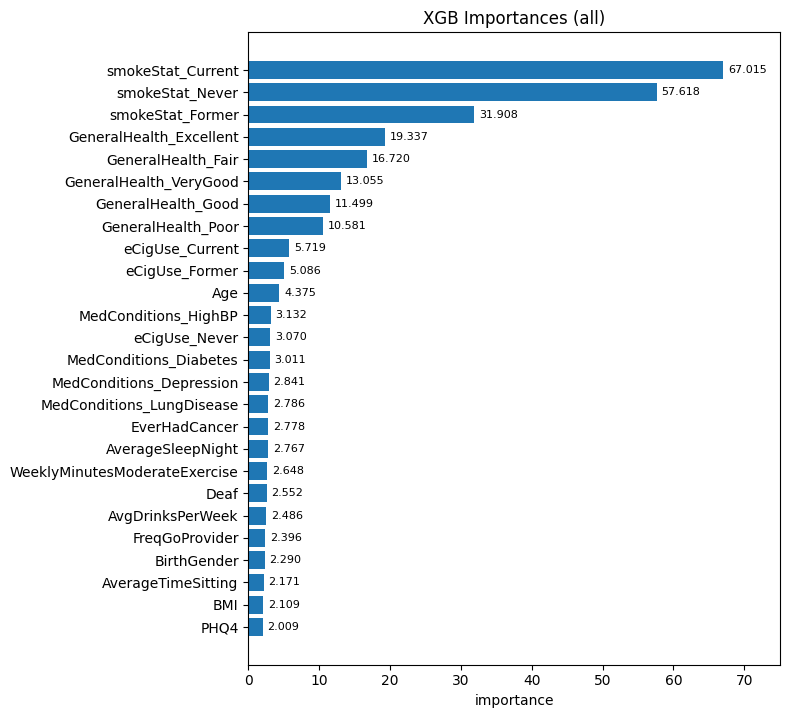

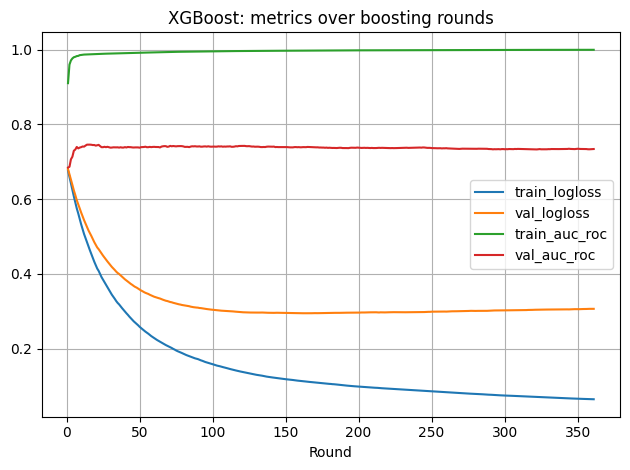

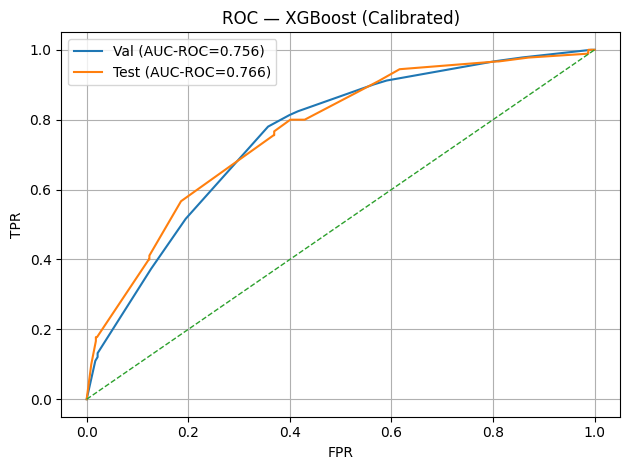

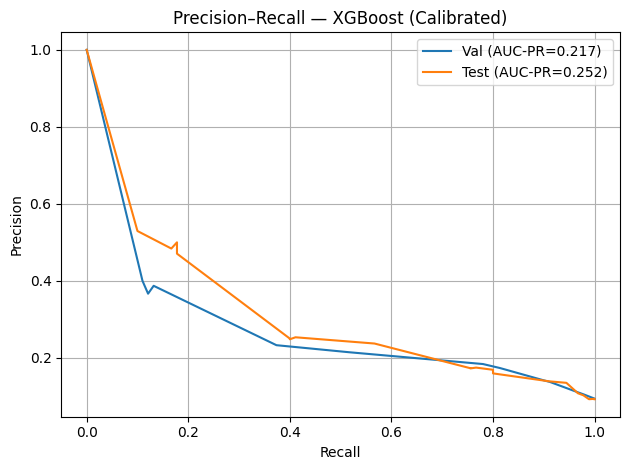

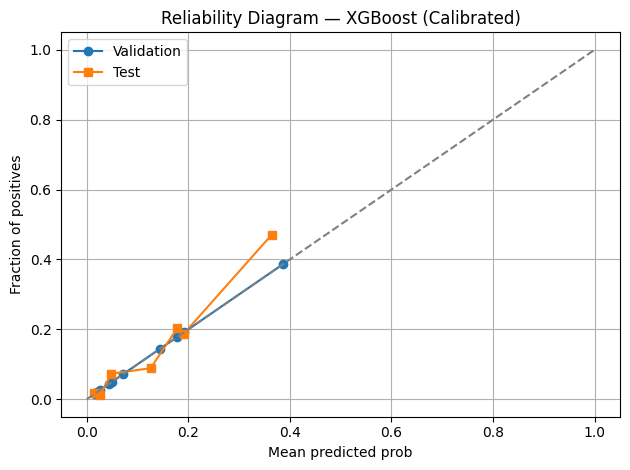

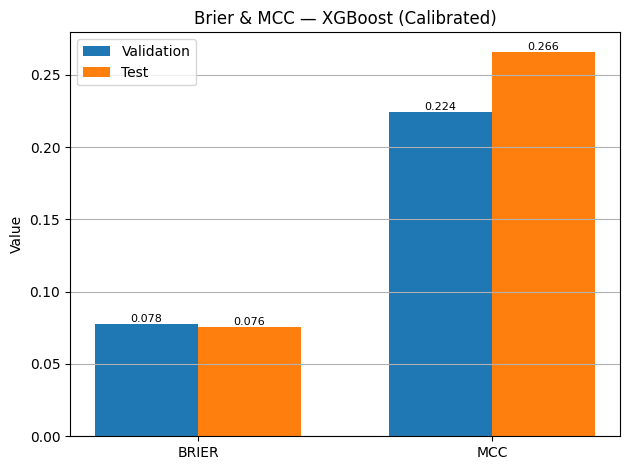

In [15]:
from utils import pipeline_xgb as pipeline_xgb
import importlib
importlib.reload(pipeline_xgb)


# Control how many features to export/plot:
# - set explicitly via topn_features (e.g., 30)
# - or set CONFIGS['XGB_TOPN_FEATURES'] (overrides the arg if present)
xgb_topn = CONFIGS.get('XGB_TOPN_FEATURES', 30)  # 0/None => ALL

results["xgb"] = pipeline_xgb.train_validate_test_xgb(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    n_estimators_grid=[600, 1200, 2000],
    learning_rate_grid=[0.03, 0.05],
    max_depth_grid=[4, 6, 8],
    min_child_weight_grid=[1.0, 3.0],
    subsample_grid=[0.8],
    colsample_bytree_grid=[0.7, 0.9],
    reg_lambda=1.0,
    early_stopping_rounds=200,
    random_state=CONFIGS.get('RANDOM_STATE', 42),
    threshold_metric="f1",          # or "youden"
    topn_features=xgb_topn,         # 0/None => ALL
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved XGB outputs dir:", results["xgb"]["outdir"])
print("XGB used top-n:", results["xgb"]["used_topn_features"])
print(results["xgb"]["features"].head(10).to_string(index=False))


[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/xlstm
[XLSTM] CUDA OOM creating model; fallback to CPU.
[XLSTM] epoch=001 train_loss=0.6956 val_logloss=0.7076 val_auc=0.3855
[XLSTM] epoch=005 train_loss=0.3691 val_logloss=0.3416 val_auc=0.5811
[XLSTM] epoch=010 train_loss=0.3142 val_logloss=0.4253 val_auc=0.5262
[XLSTM] epoch=015 train_loss=0.3016 val_logloss=0.3244 val_auc=0.6029
[XLSTM] epoch=020 train_loss=0.3027 val_logloss=0.3147 val_auc=0.6587
[XLSTM] epoch=025 train_loss=0.2678 val_logloss=0.3220 val_auc=0.6733
[XLSTM] epoch=030 train_loss=0.2564 val_logloss=0.3302 val_auc=0.6674
[XLSTM] epoch=035 train_loss=0.2546 val_logloss=0.3487 val_auc=0.6693
[XLSTM] epoch=040 train_loss=0.2427 val_logloss=0.3056 val_auc=0.7001
[XLSTM] epoch=045 train_loss=0.2483 val_logloss=0.3824 val_auc=0.6706
[XLSTM] epoch=050 train_loss=0.2380 val_logloss=0.3188 val_auc=0.6949
[XLSTM] epoch=055 train_loss=0.2369 val_logloss=0.3203 val_auc=0.690

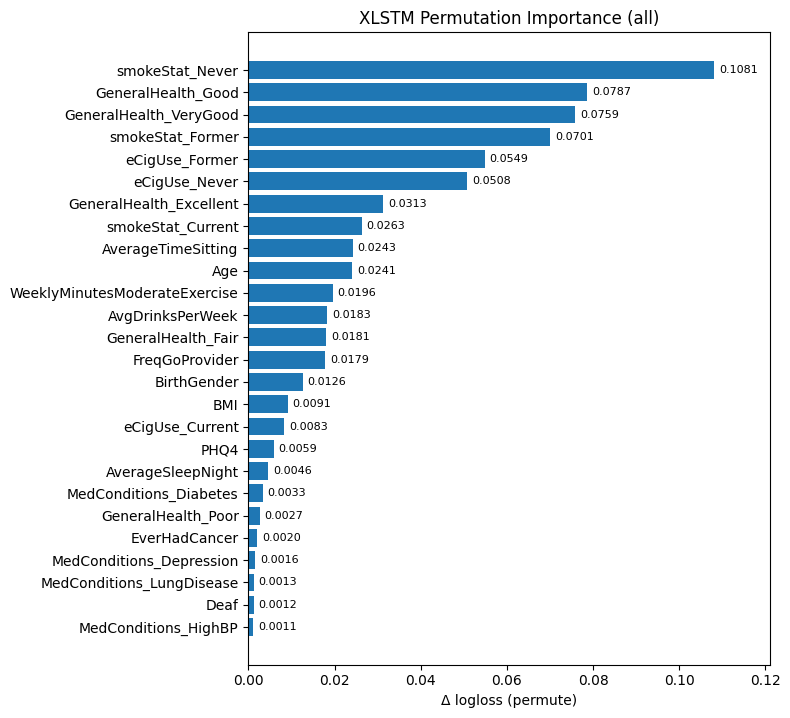

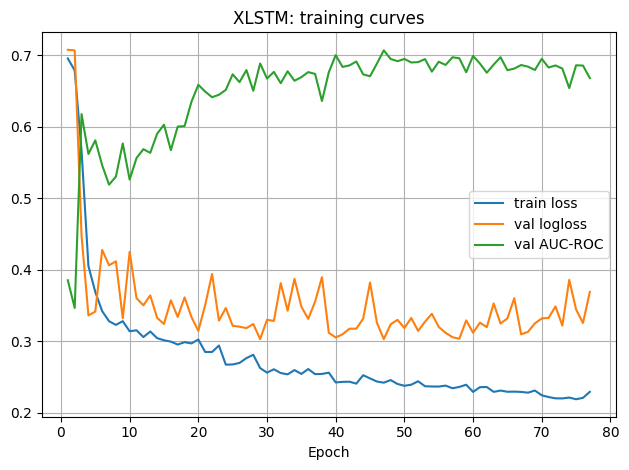

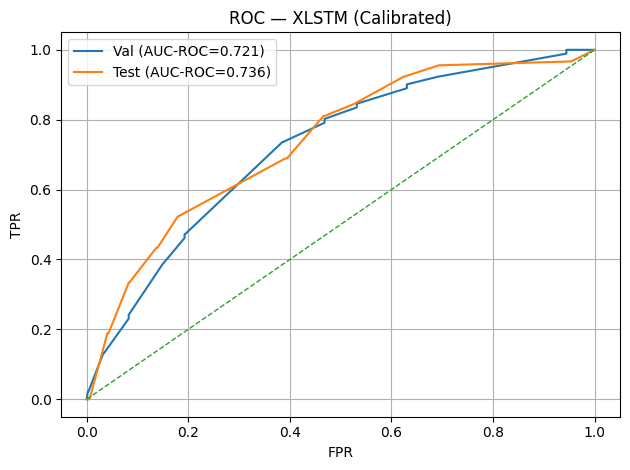

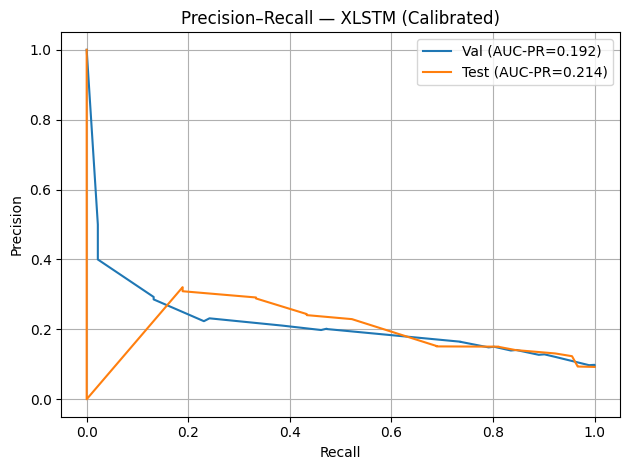

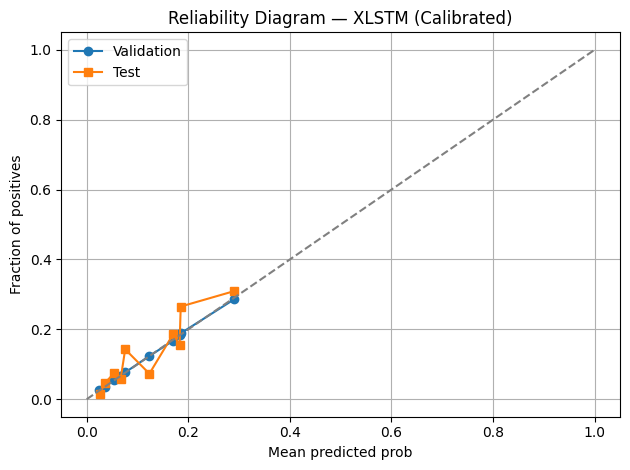

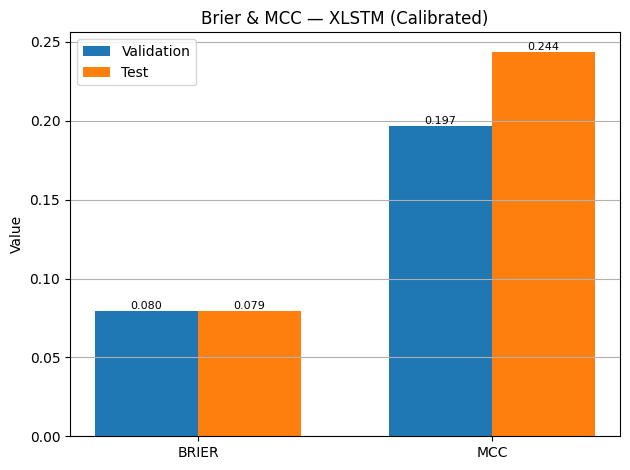

In [16]:
from utils import pipeline_xlstm as pipeline_xlstm
import importlib
importlib.reload(pipeline_xlstm)

# Control how many features to export/plot:
xlstm_topn = CONFIGS.get('XLSTM_TOPN_FEATURES', 30)  # 0/None => ALL

results["xlstm"] = pipeline_xlstm.train_validate_test_xlstm(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    hidden_dim=CONFIGS.get("XLSTM_HIDDEN", 64),
    num_layers=CONFIGS.get("XLSTM_LAYERS", 2),
    dropout=CONFIGS.get("XLSTM_DROPOUT", 0.2),
    lr=CONFIGS.get("XLSTM_LR", 1e-3),
    batch_size=CONFIGS.get("XLSTM_BS", 256),
    max_epochs=CONFIGS.get("XLSTM_EPOCHS", 120),
    patience=CONFIGS.get("XLSTM_PATIENCE", 30),
    random_state=CONFIGS.get("RANDOM_STATE", 42),
    threshold_metric="f1",            # or "youden"
    topn_features=xlstm_topn,         # 0/None => ALL
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved XLSTM outputs dir:", results["xlstm"]["outdir"])
print("Top features (head):\n", results["xlstm"]["features"].head(10).to_string(index=False))


[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/tabnet
[TABNET] Device preference: cuda (cuda_available=True)
[TABNET] Hyperparam scan (n_d/steps/batch_size):
[TABNET] CUDA trial failed (cuda error: out of memory
cuda kernel errors might be asynchronously reported at...) → falling back to CPU

Early stopping occurred at epoch 18 with best_epoch = 10 and best_val_logloss = 0.29959


/home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  n_d=12   steps=3  bs=128  dev=cpu   val_logloss=0.2996  val_auc=0.7090
[TABNET] CUDA trial failed (cuda error: out of memory
cuda kernel errors might be asynchronously reported at...) → falling back to CPU

Early stopping occurred at epoch 24 with best_epoch = 16 and best_val_logloss = 0.29687


/home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  n_d=12   steps=3  bs=256  dev=cpu   val_logloss=0.2969  val_auc=0.7643
[TABNET] CUDA trial failed (cuda error: out of memory
cuda kernel errors might be asynchronously reported at...) → falling back to CPU

Early stopping occurred at epoch 23 with best_epoch = 15 and best_val_logloss = 0.28948


/home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  n_d=12   steps=4  bs=128  dev=cpu   val_logloss=0.2895  val_auc=0.7538
[TABNET] Best: n_d=12, steps=4, batch_size=128
[TABNET] Isotonic calibration done on validation.
[TABNET][THRESH] best_t=0.150 (f1=0.3418)

Best threshold (optimized on F1 using positive-class F1): 0.15

Validation metrics (calibrated, threshold = 0.15):
  Accuracy       : 0.786
  AUC-ROC        : 0.772
  AUC-PR         : 0.227
  Brier          : 0.0769
  MCC            : 0.276
  F1 (macro_avg) : 0.607

Classification Report (Validation):
              precision    recall  f1-score   support

     Class 0       0.95      0.81      0.87       882
     Class 1       0.24      0.59      0.34        91

    accuracy                           0.79       973
   macro avg       0.60      0.70      0.61       973
weighted avg       0.88      0.79      0.82       973


Best threshold (same as VAL): 0.15

Test metrics (calibrated, threshold = 0.15):
  Accuracy       : 0.815
  AUC-ROC        : 0.797
  AUC-PR         : 0.288


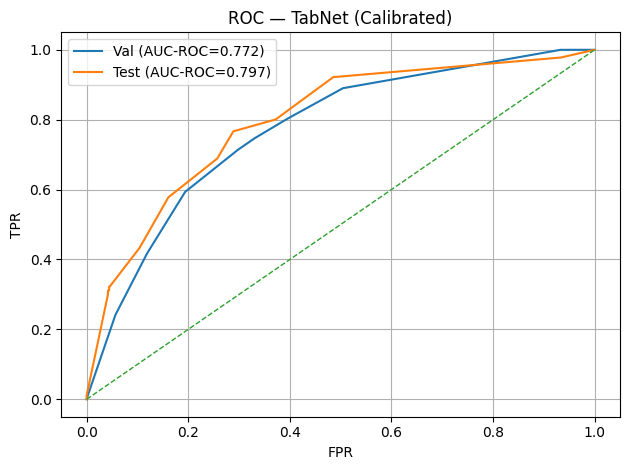

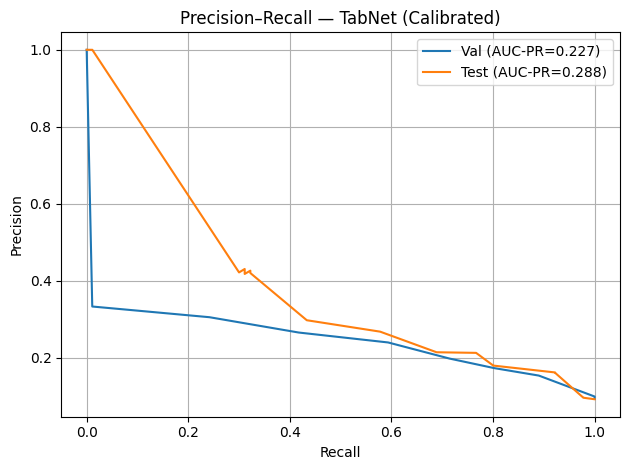

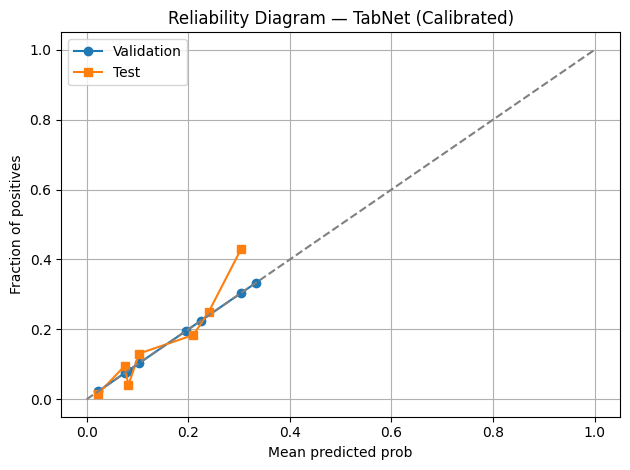

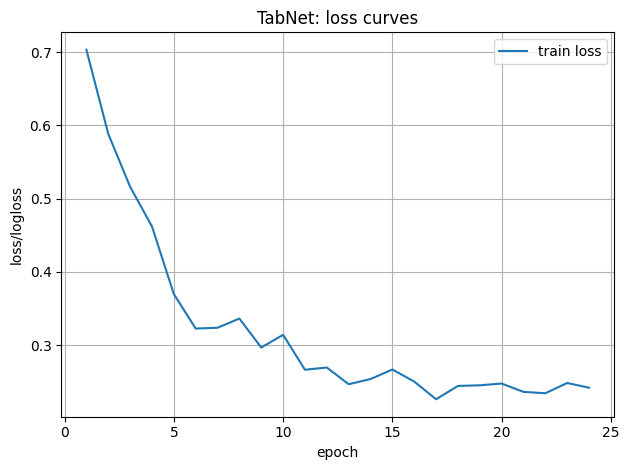

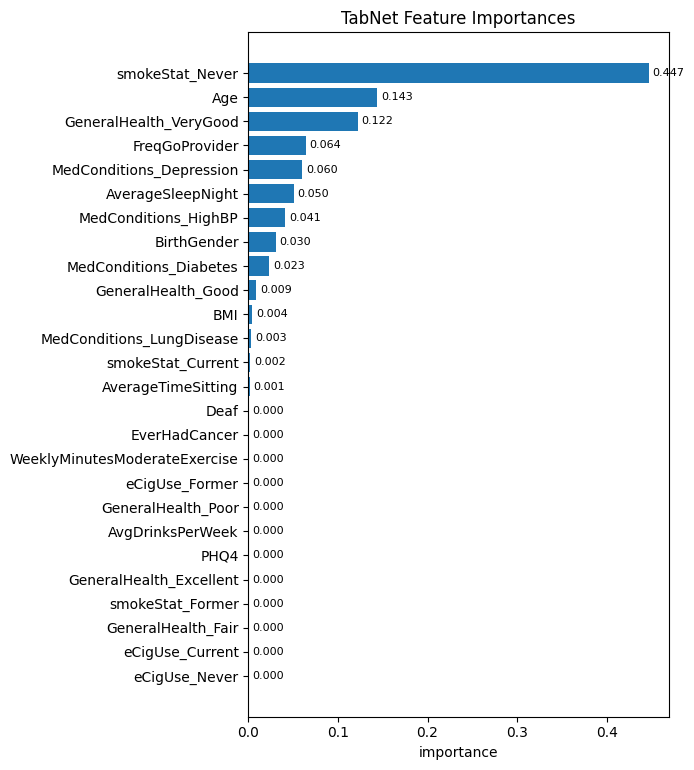

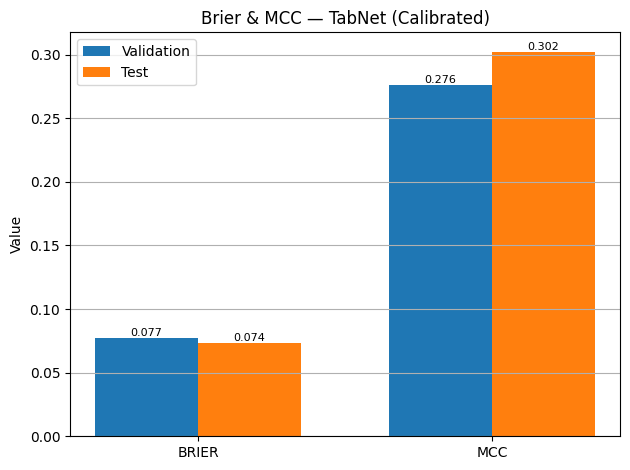

In [17]:
from utils import pipeline_tabnet as pipeline_tabnet
import importlib
importlib.reload(pipeline_tabnet)

tabnet_topn = CONFIGS.get('TABNET_TOPN_FEATURES', 30)  # 0/None => ALL

results["tabnet"] = pipeline_tabnet.train_validate_test_tabnet(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    width=CONFIGS.get("TABNET_WIDTH", 24),
    n_steps=CONFIGS.get("TABNET_STEPS", 4),
    gamma=CONFIGS.get("TABNET_GAMMA", 1.5),
    lambda_sparse=CONFIGS.get("TABNET_LAMBDA_SPARSE", 1e-5),
    mask_type=CONFIGS.get("TABNET_MASK", "sparsemax"),
    lr=CONFIGS.get("TABNET_LR", 6e-4),
    weight_decay=CONFIGS.get("TABNET_WEIGHT_DECAY", 1e-4),
    max_epochs=CONFIGS.get("TABNET_EPOCHS", 120),
    patience=CONFIGS.get("TABNET_PATIENCE", 40),
    batch_size=CONFIGS.get("TABNET_BS", 256),
    virtual_batch_size=CONFIGS.get("TABNET_VBS", 32),
    cat_idxs=CONFIGS.get("CAT_IDXS", None),
    cat_dims=CONFIGS.get("CAT_DIMS", None),
    cat_emb_dim=CONFIGS.get("CAT_EMB_DIM", 8),
    threshold_metric="f1",
    topn_features=tabnet_topn,
    CONFIGS=CONFIGS,
    device='cuda',     # force CUDA if available (falls back on OOM)
    max_trials=3,      # keep scan snappy
    early_stop_no_improve=1,
    save_outputs=True
)


[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/mlp
[MLP] Hyperparam scan:
  h=(128, 64)  alpha=0.0001  val_logloss=0.4095  val_auc=0.6946
  h=(128, 64)  alpha=0.0005  val_logloss=0.4592  val_auc=0.6932
  h=(128,)  alpha=0.0001  val_logloss=0.3408  val_auc=0.7020
  h=(128,)  alpha=0.0005  val_logloss=0.3410  val_auc=0.7007
  h=(64,)  alpha=0.0001  val_logloss=0.3239  val_auc=0.7148
  h=(64,)  alpha=0.0005  val_logloss=0.3240  val_auc=0.7147
  h=(256, 128)  alpha=0.0001  val_logloss=0.4689  val_auc=0.6805
  h=(256, 128)  alpha=0.0005  val_logloss=0.5701  val_auc=0.6476
[MLP] Best hidden=(64,), alpha=0.0001 selected by val_logloss (tie-break AUC).
[MLP] Isotonic calibration done on validation.
[MLP][THRESH] best_t=0.150 (f1=0.3000)

Best threshold (F1 on VAL): 0.15

Validation metrics (calibrated, threshold = 0.15):
  Accuracy       : 0.770
  AUC-ROC        : 0.733
  AUC-PR         : 0.187
  Brier          : 0.0795
  MCC          

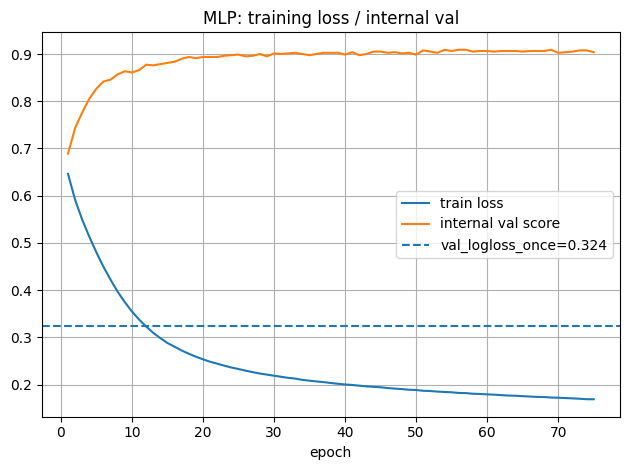

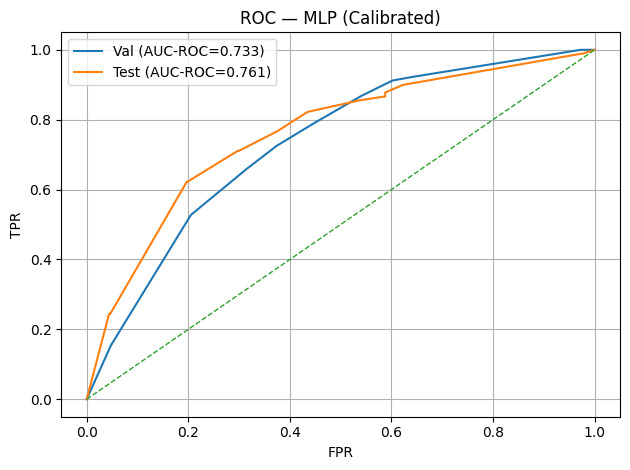

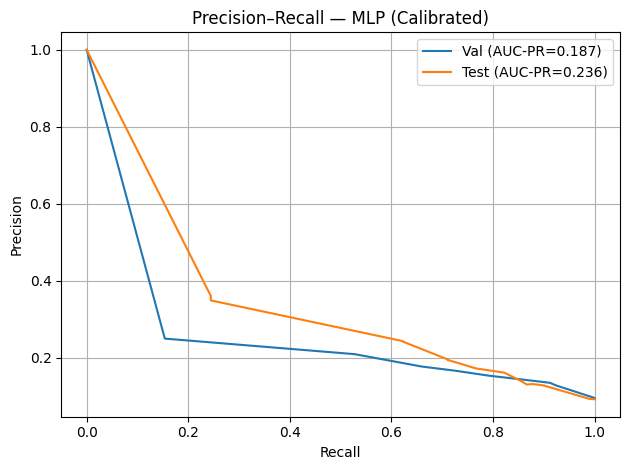

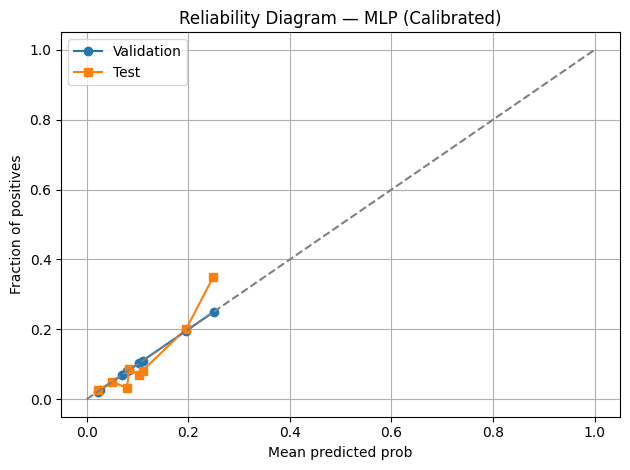

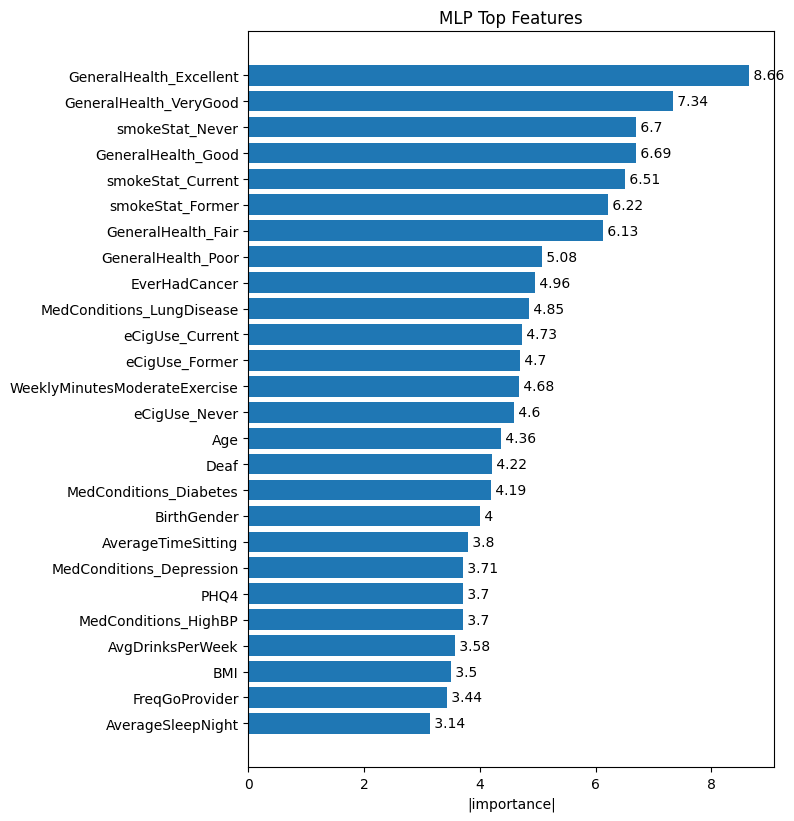

In [18]:
import utils.pipeline_mlp as pipeline_mlp

import importlib
importlib.reload(pipeline_mlp)

# Control how many features to export/plot:
mlp_topn = CONFIGS.get('MLP_TOPN_FEATURES', 30)   # 0/None => ALL

results["mlp"] = pipeline_mlp.train_validate_test_mlp(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    hidden_grid=[(128,64), (128,), (64,), (256,128)],
    alpha_grid=[1e-4, 5e-4],
    learning_rate_init=8e-4,
    max_iter=400,
    random_state=CONFIGS.get("RANDOM_STATE", 42),
    threshold_metric="f1",         # or "youden"
    topn_features=mlp_topn,        # 0/None => ALL features
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved MLP dir:", results["mlp"]["outdir"])
print("\nVal summary:\n", results["mlp"]["val_summary_df"])
print("\nTest summary:\n", results["mlp"]["test_summary_df"])
print("\nTop features (head):\n", results["mlp"]["features"].head(10).to_string(index=False))


In [19]:
import utils.shap_utils as shap_utils

import importlib
importlib.reload(shap_utils)

<module 'utils.shap_utils' from '/home/ppanta/puru_proj/proj_v0/hints6_v0/utils/shap_utils.py'>

In [20]:
# Use actual estimators
models = {
    "lr":    results["lr"]["lr_raw"],
    "rf":    results["rf"]["rf_raw"],
    "xgb":   results["xgb"]["xgb_raw"],
    "mlp":   results["mlp"]["mlp_raw"],
    "xlstm": results["xlstm"]["xlstm_model"],
    # "tabnet": results["tabnet"]["tabnet_model"],  # add if you have it. Tabnet normally dont use external SHAP. It provides its importance value itself.
}

# Provide test matrices; others fall back to "default"
X_by_model = {
    "lr": X_test_scaled,   # if RF/XGB used raw features, add: "rf": X_test_raw, "xgb": X_test_raw
    "default": X_test_scaled
}

global_csv_path = shap_utils.write_shap_reports(
    models=models,
    X_by_model=X_by_model,
    feature_names=list(X_test_scaled.columns),
    CONFIGS=CONFIGS,
    verbose=True
)



 =====> SHAP Analysis (permutation) for Logistic Regression (lr) starting ... <=====
 =====> SHAP Analysis for Logistic Regression (lr) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/lr/local_shap_20251202_200541.csv saved <=====
 =====> SHAP Analysis for Logistic Regression (lr) end. <=====

 =====> SHAP Analysis (permutation) for Random Forest (rf) starting ... <=====
 =====> SHAP Analysis for Random Forest (rf) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/rf/local_shap_20251202_200541.csv saved <=====
 =====> SHAP Analysis for Random Forest (rf) end. <=====

 =====> SHAP Analysis (permutation) for XGBoost (xgb) starting ... <=====
 =====> SHAP Analysis for XGBoost (xgb) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/xgb/local_shap_20251202_200541.csv saved <=====
 =====> SHAP Analysis for XGBoost (xgb) end. <=====

 =====> SHAP A

PermutationExplainer explainer: 974it [00:20, 36.23it/s]                                                                                                                                                                                     


 =====> SHAP Analysis for Neural Network (MLP) (mlp) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/mlp/local_shap_20251202_200541.csv saved <=====
 =====> SHAP Analysis for Neural Network (MLP) (mlp) end. <=====

 =====> SHAP Analysis (permutation) for XLSTM (xlstm) starting ... <=====


PermutationExplainer explainer: 974it [04:45,  3.31it/s]                                                                                                                                                                                     

 =====> SHAP Analysis for XLSTM (xlstm) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/xlstm/local_shap_20251202_200541.csv saved <=====
 =====> SHAP Analysis for XLSTM (xlstm) end. <=====
 =====> SHAP Analysis for all models (lr, rf, xgb, mlp, xlstm) done and result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/global_shap_20251202_200541.csv saved <=====


In [21]:
# assuming you already have: results dict, CONFIGS, feature_names, and per-model X_test matrices
# tip: pass a 'default' in X_by_model if most models share the same test matrix

models = {}
models = {k: results[k] for k in ["lr","rf","mlp","xgb","xlstm","tabnet"] if k in results}

X_by_model = {
    "lr": X_test_scaled,
    "rf": X_test,        # adjust per your pipelines
    "mlp": X_test_scaled,
    "xgb": X_test,
    "xlstm": X_test_scaled,
    "tabnet": X_test,
    "default": X_test_scaled
}

# import shap_utils
global_csv_path = shap_utils.write_shap_reports(
    models=models,
    X_by_model=X_by_model,
    feature_names=list(X_by_model["default"].columns),
    CONFIGS=CONFIGS
)
print("Global SHAP:", global_csv_path)



 =====> SHAP Analysis (permutation) for Logistic Regression (lr) starting ... <=====
 =====> SHAP Analysis for Logistic Regression (lr) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/lr/local_shap_20251202_200541.csv saved <=====
 =====> SHAP Analysis for Logistic Regression (lr) end. <=====

 =====> SHAP Analysis (permutation) for Random Forest (rf) starting ... <=====
 =====> SHAP Analysis for Random Forest (rf) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/rf/local_shap_20251202_200541.csv saved <=====
 =====> SHAP Analysis for Random Forest (rf) end. <=====

 =====> SHAP Analysis (permutation) for Neural Network (MLP) (mlp) starting ... <=====


PermutationExplainer explainer: 974it [00:13, 18.47it/s]                                                                                                                                                                                     


 =====> SHAP Analysis for Neural Network (MLP) (mlp) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/mlp/local_shap_20251202_200541.csv saved <=====
 =====> SHAP Analysis for Neural Network (MLP) (mlp) end. <=====

 =====> SHAP Analysis (permutation) for XGBoost (xgb) starting ... <=====
 =====> SHAP Analysis for XGBoost (xgb) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/xgb/local_shap_20251202_200541.csv saved <=====
 =====> SHAP Analysis for XGBoost (xgb) end. <=====

 =====> SHAP Analysis (permutation) for XLSTM (xlstm) starting ... <=====


PermutationExplainer explainer: 974it [04:44,  3.30it/s]                                                                                                                                                                                     

 =====> SHAP Analysis for XLSTM (xlstm) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/xlstm/local_shap_20251202_200541.csv saved <=====
 =====> SHAP Analysis for XLSTM (xlstm) end. <=====

 =====> SHAP Analysis (permutation) for TabNet (tabnet) starting ... <=====
##### [WARN] SHAP Analysis for TabNet (tabnet) failed: 0 #####
 =====> SHAP Analysis for all models (lr, rf, mlp, xgb, xlstm) done and result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251202_200541/global_shap_20251202_200541.csv saved <=====
Global SHAP: op/tr_va_te_metric_shap_20251202_200541/global_shap_20251202_200541.csv


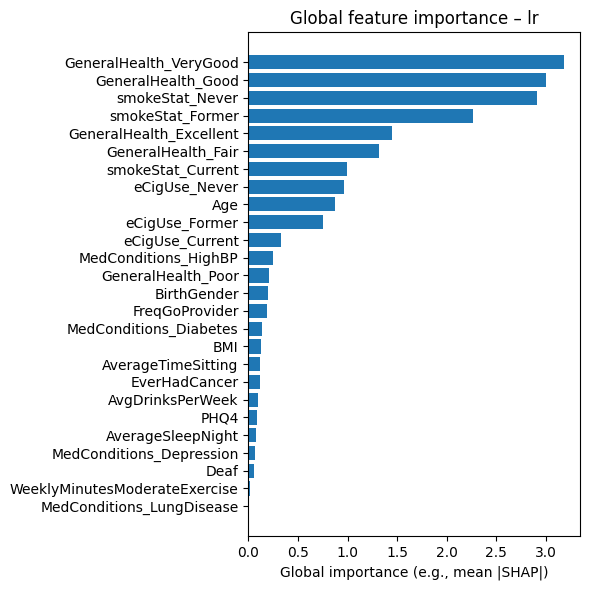

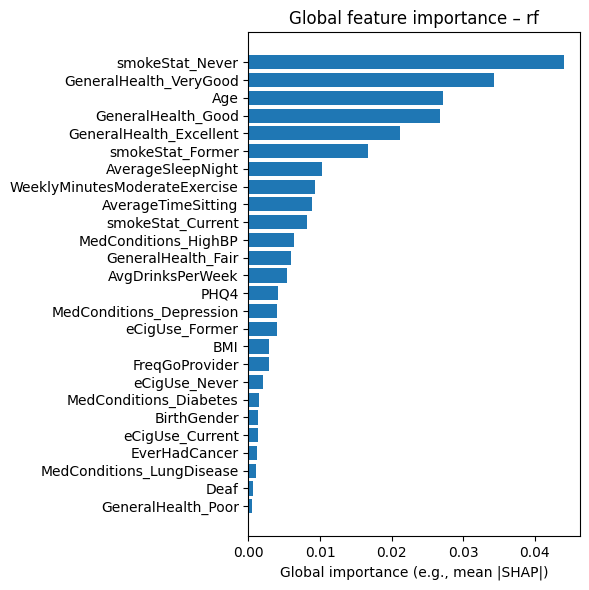

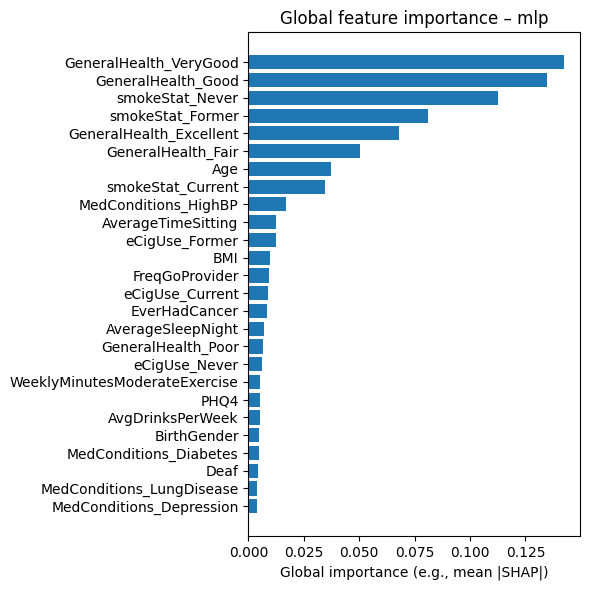

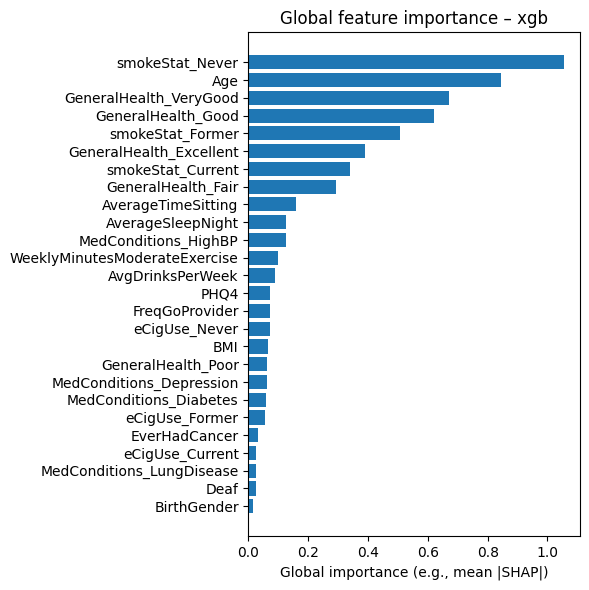

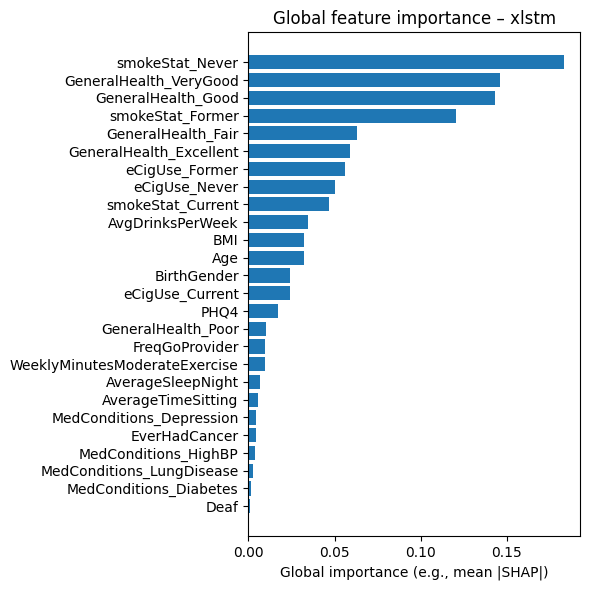

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# path to your global SHAP file
global_csv_path = f"op/tr_va_te_metric_shap_{CONFIGS['RUN_TS']}/global_shap_{CONFIGS['RUN_TS']}.csv"
gdf = pd.read_csv(global_csv_path)

# columns of the form "<model>_shap_abs" are global importance for each model
model_cols = [c for c in gdf.columns if c.endswith("_shap_abs")]

for col in model_cols:
    model_name = col.replace("_shap_abs", "")  # e.g. "rf", "xgb", "lr", "mlp", "xlstm"

    # sort features by importance for this model
    gdf_sorted = gdf.sort_values(col, ascending=False)

    plt.figure(figsize=(6, 6))
    plt.barh(gdf_sorted["feature"], gdf_sorted[col])
    plt.gca().invert_yaxis()  # highest at top
    plt.xlabel("Global importance (e.g., mean |SHAP|)")
    plt.title(f"Global feature importance – {model_name}")
    plt.tight_layout()
    plt.show()


In [ ]:
####
# NOT USING THE FOLLOWING MODEL FOR NOW #
####

In [ ]:
import utils.pipeline_node as pipeline_node
import importlib
importlib.reload(pipeline_node)

node_topn = CONFIGS.get('NODE_TOPN_FEATURES', 30)  # 0/None => ALL

results["node"] = pipeline_node.train_validate_test_node(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    num_trees_grid=[64, 128],
    depth_grid=[3, 4],
    lr_grid=[1e-3, 3e-4],
    batch_size_grid=[256, 512],
    max_epochs=CONFIGS.get("NODE_EPOCHS", 120),
    patience=CONFIGS.get("NODE_PATIENCE", 40),
    random_state=CONFIGS.get("RANDOM_STATE", 42),
    threshold_metric="f1",        # or "youden"
    topn_features=node_topn,      # 0/None => ALL features
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved NODE dir:", results["node"]["outdir"])
print("\nVal summary:\n", results["node"]["val_summary_df"])
print("\nTest summary:\n", results["node"]["test_summary_df"])
print("\nTop features (head):\n", results["node"]["features"].head(10).to_string(index=False))
